# Pan01 Bottom Temperature

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35341,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:40413,Total threads: 1
Dashboard: /proxy/37097/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:34625,


In [8]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))#[-66:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month.nc'))

In [9]:
# Shelf mask
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

MOM5 "sfc_salt_flux_ice" + "sfc_salt_flux_restore" = MOM6 "salt_flux"


In [30]:
#Time variant variables
def preprocess(ds):
    ds = ds[['salt_flux_added','wfo']].sel(yh=slice(None,-59))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [31]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [32]:
cont_mean = cont['salt_flux_added'].mean(dim=['xh','yh'])
cont_mean_wfo = cont['wfo'].mean(dim=['xh','yh'])
melt_mean = melt['salt_flux_added'].mean(dim=['xh','yh'])
melt_mean_wfo = melt['wfo'].mean(dim=['xh','yh'])



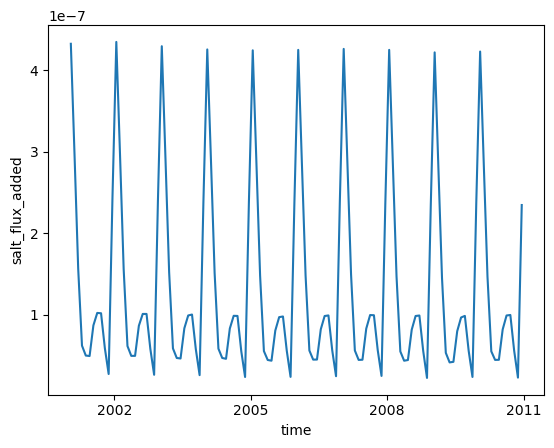

In [33]:
cont_mean.plot()

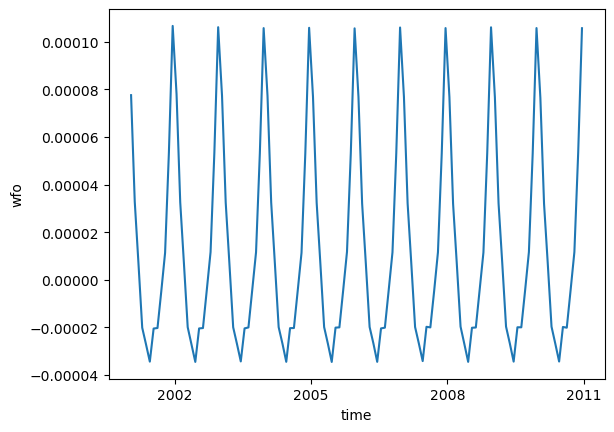

In [34]:
cont_mean_wfo.plot()

In [8]:
#Time invariant variables
depth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
areaC = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [9]:
# Temperature variable
tempC = cont['thetao']
tempM = melt['thetao']

In [10]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'z_l': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [11]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'z_l': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

#### Mapping

In [14]:
bottemp_cont_map = tempC.where(bottom_mask_tempC).sum(dim='z_l').mean(dim='time')
bottemp_pert_map = tempM.where(bottom_mask_tempM).sum(dim='z_l').mean(dim='time')
bottemp_anom_ave = bottemp_pert_map - bottemp_cont_map

In [16]:
bottemp_anom_ave = bottemp_anom_ave.load()

In [17]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [18]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

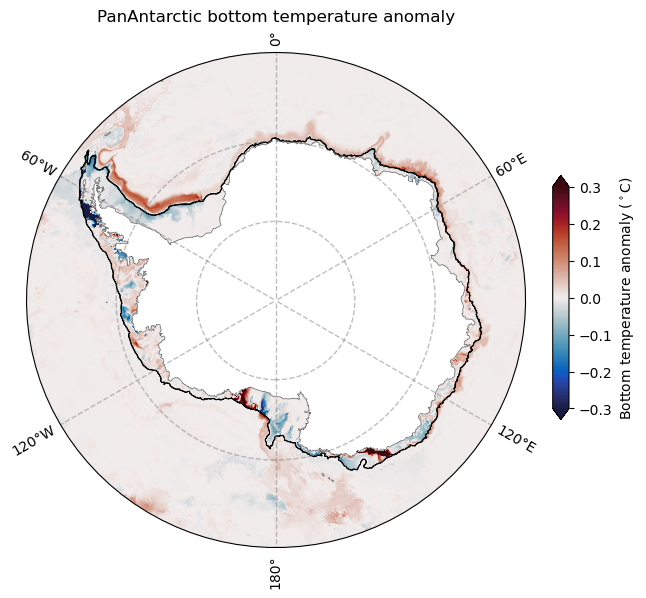

In [21]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_anom_ave.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic bottom temperature anomaly");

#### Time series

In [12]:
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='z_l')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='z_l')

In [15]:
bottemp_cont = bottemp_cont.mean(dim=['xh','yh'])
bottemp_pert = bottemp_pert.mean(dim=['xh','yh'])

In [16]:
bottemp_cont = bottemp_cont.load()
bottemp_pert = bottemp_pert.load()

In [17]:
bottemp_anom = bottemp_pert - bottemp_cont
bottemp_anom = bottemp_anom.load()

In [18]:
bottemp_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_bottemp_anom.nc')

### Comparison with ACCESS

In [19]:
pan01_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_bottemp_anom.nc', chunks = 'auto')
acc_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/access_bottemp_anom.nc', chunks = 'auto')

In [35]:
pan01_bottemp_anom_new = pan01_bottemp_anom.to_series()
acc_bottemp_anom_new = acc_bottemp_anom.to_series()

In [36]:
import pandas as pd

In [37]:
# Slice 1910–1919 and 2001–2010
pan01_bottemp_anom_new = pan01_bottemp_anom_new['2001-01-01':'2010-10-16']
acc_bottemp_anom_new = acc_bottemp_anom_new['1910-01-01':'1919-10-16']

# Reset index to normalized months
pan01_bottemp_anom_new.index = range(1, len(pan01_bottemp_anom_new)+1)
acc_bottemp_anom_new.index = range(1, len(acc_bottemp_anom_new)+1)

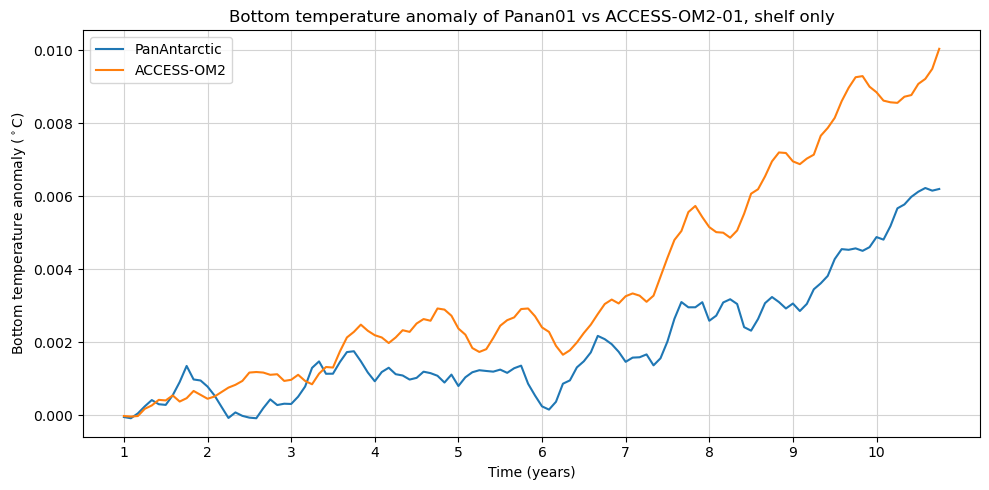

In [41]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(pan01_bottemp_anom_new.index, pan01_bottemp_anom_new.values, label='PanAntarctic')
plt.plot(acc_bottemp_anom_new.index, acc_bottemp_anom_new.values, label='ACCESS-OM2')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.title('Bottom temperature anomaly of Panan01 vs ACCESS-OM2-01, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()